In [110]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import matplotlib

print(matplotlib.get_configdir())

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                   ha="center")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # 找出最大值
    max_value = data.max()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # 如果是最大值，使用红色；否则使用指定的颜色
            if data[i, j] == max_value:
                kw.update(color="red")
            # 如果值大于阈值，使用黑色
            elif i ==7:
                kw.update(color="white")
            # 如果值小于阈值，使用白色
            else:
                kw.update(color="black")
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

/home/cartolab3/.config/matplotlib


                                     params    R@1    R@5   R@10
0                  tokyo247_dataset_0.1_0.1  94.92  98.41  99.05
1                  tokyo247_dataset_0.1_0.2  94.92  98.41  99.05
2  tokyo247_dataset_0.1_0.30000000000000004  94.92  98.41  99.05
3                  tokyo247_dataset_0.1_0.4  94.92  98.41  99.05
4                  tokyo247_dataset_0.1_0.5  94.92  98.10  99.05


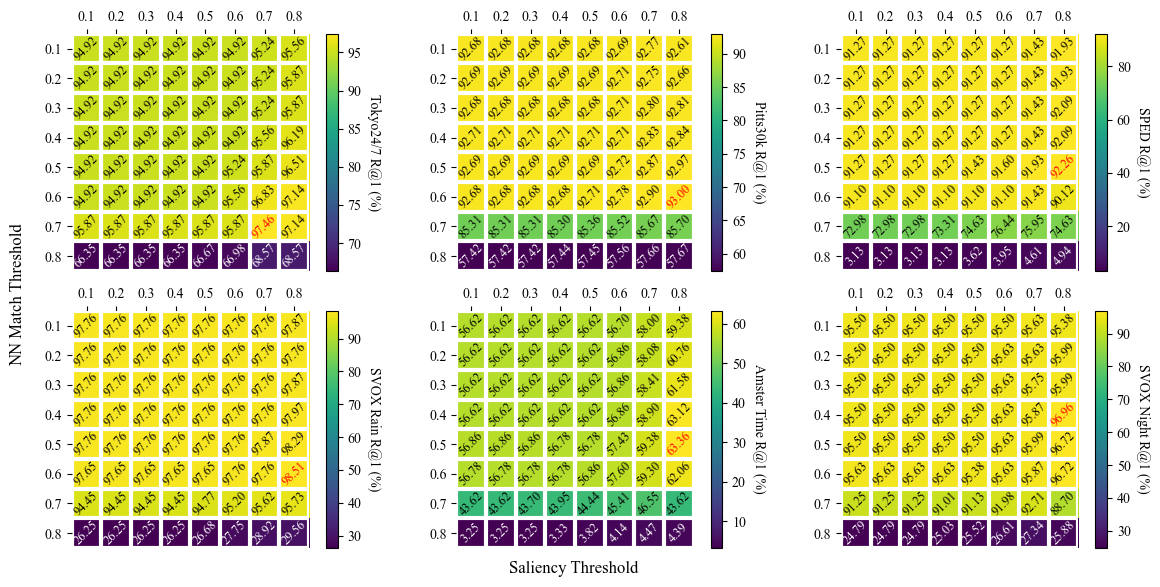

In [119]:
df=pd.read_excel('tmp_files/param_heatmap.xlsx')
print(df.head())

datasets=['tokyo247', 'pittsburg30k', 'spedtest', 'svoxrain', 'amstertime','svoxnight']
datasets_name=['Tokyo24/7', 'Pitts30k', 'SPED', 'SVOX Rain', 'Amster Time','SVOX Night']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
plt.rcParams['font.family'] = 'Times New Roman'

for index, dataset in enumerate(datasets):

    # 从df的params列中提取出dataset对应的参数
    params=df[df['params'].str.contains(dataset)]

    # 创建用于热力图的数据矩阵
    saliency_values = np.round(np.arange(0.1, 0.9, 0.1), 1).tolist()   # saliency阈值范围
    nn_values = np.round(np.arange(0.1, 0.9, 0.1), 1).tolist()        # nn_match阈值范围
    heatmap_data = np.zeros((len(saliency_values), len(nn_values)))

    # 遍历params每行数据
    for i, row in params.iterrows():
        saliency_thresh=np.round(float(row['params'].split('_')[2]), 1)
        nn_match_thresh=np.round(float(row['params'].split('_')[3]), 1)

        # 找到对应的索引位置
        i = np.where(saliency_values == saliency_thresh)[0][0]
        j = np.where(nn_values == nn_match_thresh)[0][0]

        # 将recall值填入矩阵
        value=row['R@1']
        heatmap_data[i, j] = value

    ax = axes[index // 3, index % 3]
    im, cbar = heatmap(heatmap_data, nn_values, saliency_values, ax=ax,
                    cmap="viridis", cbarlabel=f"{datasets_name[index]} R@1 (%)")
    texts = annotate_heatmap(im, valfmt="{x:.2f}",fontsize=9,rotation=45)


# 添加整体的x轴和y轴标签
fig.supxlabel('Saliency Threshold', fontsize=12, y=0.03)  # 增大y值使标签向上移动
fig.supylabel('NN Match Threshold', fontsize=12, x=0.03)  # 增大x值使标签向右移动
fig.tight_layout()

plt.savefig('images/param_heatmap.png', dpi=600,bbox_inches='tight')
plt.show()


